In [1]:
import pandas as pd
import sqlite3

Условия
Дан csv-файл с транзакциями с 2023–01-01 до 2023-04-20. Необходимо в Jupyter-ноутбуке выполнить следующие пункты, используя SQLite:

### Шаг 1
(Балл - 0.2) Необходимо скачать CSV-файл — «final_transactions.csv», создать таблицу transaction_bd со всеми полями, загрузить данные из файла в таблицу и оставить таблицу со структурой:

(0, 'TX_DATETIME', 'NUMERIC', 0, None, 0) - время транзакций

(1, 'CUSTOMER_ID', 'INTEGER', 0, None, 0) - клиент

(2, 'TX_AMOUNT', 'REAL', 0, None, 0) - сумма транзакций

Комментарий: Можно оставить все 5 полей, но запросы будут выполняться чуть дольше.

In [2]:
df = pd.read_csv('./final_transactions.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   TRANSACTION_ID  1048575 non-null  int64  
 1   TX_DATETIME     1048575 non-null  object 
 2   CUSTOMER_ID     1048575 non-null  int64  
 3   TERMINAL_ID     1048575 non-null  int64  
 4   TX_AMOUNT       1048575 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 40.0+ MB


In [4]:
df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT
0,0,2023-01-01 00:00:31,596,3156,533.07
1,1,2023-01-01 00:02:10,4961,3412,808.56
2,2,2023-01-01 00:07:56,2,1365,1442.94
3,3,2023-01-01 00:09:29,4128,8737,620.65
4,4,2023-01-01 00:10:34,927,9906,490.66


In [5]:
con = sqlite3.connect("./transaction_bd.db")
sql_drop = "DROP TABLE IF EXISTS final_transactions;"
sql_create = """
CREATE TABLE final_transactions ( 
    TRANSACTION_ID INTEGER PRIMARY KEY, 
    TX_DATETIME    NUMERIC NOT NULL, 
    CUSTOMER_ID    INTEGER NOT NULL, 
    TERMINAL_ID    INTEGER NOT NULL, 
    TX_AMOUNT      REAL    NOT NULL
);"""
cur = con.cursor()
cur.execute(sql_drop)
cur.execute(sql_create)
con.commit()

In [6]:
sql_insert = """INSERT INTO final_transactions (
                                   TRANSACTION_ID,
                                   TX_DATETIME,
                                   CUSTOMER_ID,
                                   TERMINAL_ID,
                                   TX_AMOUNT
                               )
                               VALUES (
                                   ?,
                                   ?,
                                   ?,
                                   ?,
                                   ?
                               );"""

con.executemany(sql_insert, df.values.tolist())
con.commit()

### Шаг 2

(Балл - 0.1 за каждый пункт) Написать следующие запросы к таблице transaction_bd:

In [7]:
# A. Вывести всех клиентов, у которых сумма транзакций больше 700000 за весь период (сортируя клиентов по возрастанию);
sql_query_a = """
SELECT
    CUSTOMER_ID
    --,SUM(TX_AMOUNT) as SUM_TOTAL
FROM final_transactions
GROUP BY CUSTOMER_ID 
HAVING SUM(TX_AMOUNT) > 700000
ORDER BY CUSTOMER_ID"""

table_a = pd.read_sql(sql_query_a, con)
print(table_a)

   CUSTOMER_ID
0          389
1         2249
2         2891
3         3116
4         4163


In [8]:
# B. Вывести всех клиентов, у которых сумма транзакций больше 200000 за период 01.01.2023 - 13.01.2023 (сортируя клиентов по возрастанию);
sql_query_b = """
SELECT
    CUSTOMER_ID
    --,SUM(TX_AMOUNT) as SUM_TOTAL
FROM final_transactions
WHERE TX_DATETIME between '2023-01-01' and '2023-01-13'
GROUP BY CUSTOMER_ID 
HAVING SUM(TX_AMOUNT) > 200000
ORDER BY CUSTOMER_ID"""
table_b = pd.read_sql(sql_query_b, con)
print(table_b)

   CUSTOMER_ID
0         1918
1         3406
2         3833
3         4252


In [9]:
# C. Вывести тех клиентов, у которых id начинается с 4 и количество транзакций за весь период более 444;
sql_query_c = """
SELECT 
	CUSTOMER_ID
	--,COUNT(TRANSACTION_ID) as TR_COUNT
FROM final_transactions
WHERE SUBSTRING(CUSTOMER_ID,1,1) = '4'
GROUP BY CUSTOMER_ID
HAVING COUNT(TRANSACTION_ID) > 444;"""
table_c = pd.read_sql(sql_query_c, con)
print(table_c)

   CUSTOMER_ID
0         4231
1         4539
2         4661


In [10]:
# D. Создать флаг доходности клиентов по логике:
   # 1. Если сумма транзакций не более 50000, тогда вывести 'низкая доходность';
   # 2. Если сумма транзакций больше 50000 и не более 10000 тогда вывести 'средняя доходность';
   # 3. Если сумма транзакций больше 100000 тогда вывести 'высокая доходность'.

sql_query_d = """
SELECT
	CUSTOMER_ID,
	case
		when not sum(TX_AMOUNT) > 5000 then 'низкая доходность'
		when sum(TX_AMOUNT) > 5000 and not sum(TX_AMOUNT) > 100000 then 'средняя доходность'
		when sum(TX_AMOUNT) > 100000 then 'высокая доходность'
	end PROFIT_LEVEL
FROM final_transactions
group by CUSTOMER_ID;"""
table_d = pd.read_sql(sql_query_d, con)
print(table_d)

      CUSTOMER_ID        PROFIT_LEVEL
0               0  высокая доходность
1               1  высокая доходность
2               2  высокая доходность
3               3   низкая доходность
4               4  высокая доходность
...           ...                 ...
4981         4995  высокая доходность
4982         4996  средняя доходность
4983         4997  высокая доходность
4984         4998  высокая доходность
4985         4999  высокая доходность

[4986 rows x 2 columns]


In [11]:
# E. Посмотреть количество клиентов с каждым видом доходности (из пункта 2.d);
sql_query_e = """
SELECT
	PROFIT_LEVEL,
	COUNT(CUSTOMER_ID)
FROM
(SELECT
	CUSTOMER_ID,
	case
		when not sum(TX_AMOUNT) > 5000 then 'низкая доходность'
		when sum(TX_AMOUNT) > 5000 and not sum(TX_AMOUNT) > 100000 then 'средняя доходность'
		when sum(TX_AMOUNT) > 100000 then 'высокая доходность'
	end PROFIT_LEVEL
FROM final_transactions
group by CUSTOMER_ID)
GROUP BY PROFIT_LEVEL;"""
table_e = pd.read_sql(sql_query_e, con)
print(table_e)

         PROFIT_LEVEL  COUNT(CUSTOMER_ID)
0  высокая доходность                2167
1   низкая доходность                 299
2  средняя доходность                2520


In [12]:
# F. Вывести сумму транзакций за каждый день (сортируя дни по возрастанию).

sql_query_f = """
SELECT
	DATE(TX_DATETIME) AS TX_DATE,
	SUM(TX_AMOUNT)
FROM final_transactions
GROUP BY DATE(TX_DATETIME)
ORDER BY DATE(TX_DATETIME);"""
table_f = pd.read_sql(sql_query_f, con)
print(table_f)

        TX_DATE  SUM(TX_AMOUNT)
0    2023-01-01      4827656.26
1    2023-01-02      4862551.41
2    2023-01-03      5058973.71
3    2023-01-04      4938142.47
4    2023-01-05      5002954.23
..          ...             ...
105  2023-04-16      5299386.81
106  2023-04-17      5100973.31
107  2023-04-18      5233557.39
108  2023-04-19      5194846.44
109  2023-04-20      1795235.72

[110 rows x 2 columns]


### Шаг 3

(Балл - 0.2) Подготовить дашборд с помощью Dash по пункту 2.f, включив туда графики bar и histogram; вставить в конце ноутбука скрин графиков из дашборда.

In [ ]:
from dash import Dash, html, dcc
import plotly.express as px

# Initialize the app
app = Dash()

# App layout
app.layout = html.Div([
    html.Div(children='(Балл - 0.2) Подготовить дашборд с помощью Dash по пункту 2.f, включив туда графики bar и histogram; вставить в конце ноутбука скрин графиков из дашборда.'),
    dcc.Graph(figure=px.bar(df, x='TX_DATE', y='SUM_TX_AMOUNT')),
    dcc.Graph(figure=px.histogram(df, x='TX_DATE', y='SUM_TX_AMOUNT', histfunc='sum'))
])

# Run the app
app.run_server(debug=True)

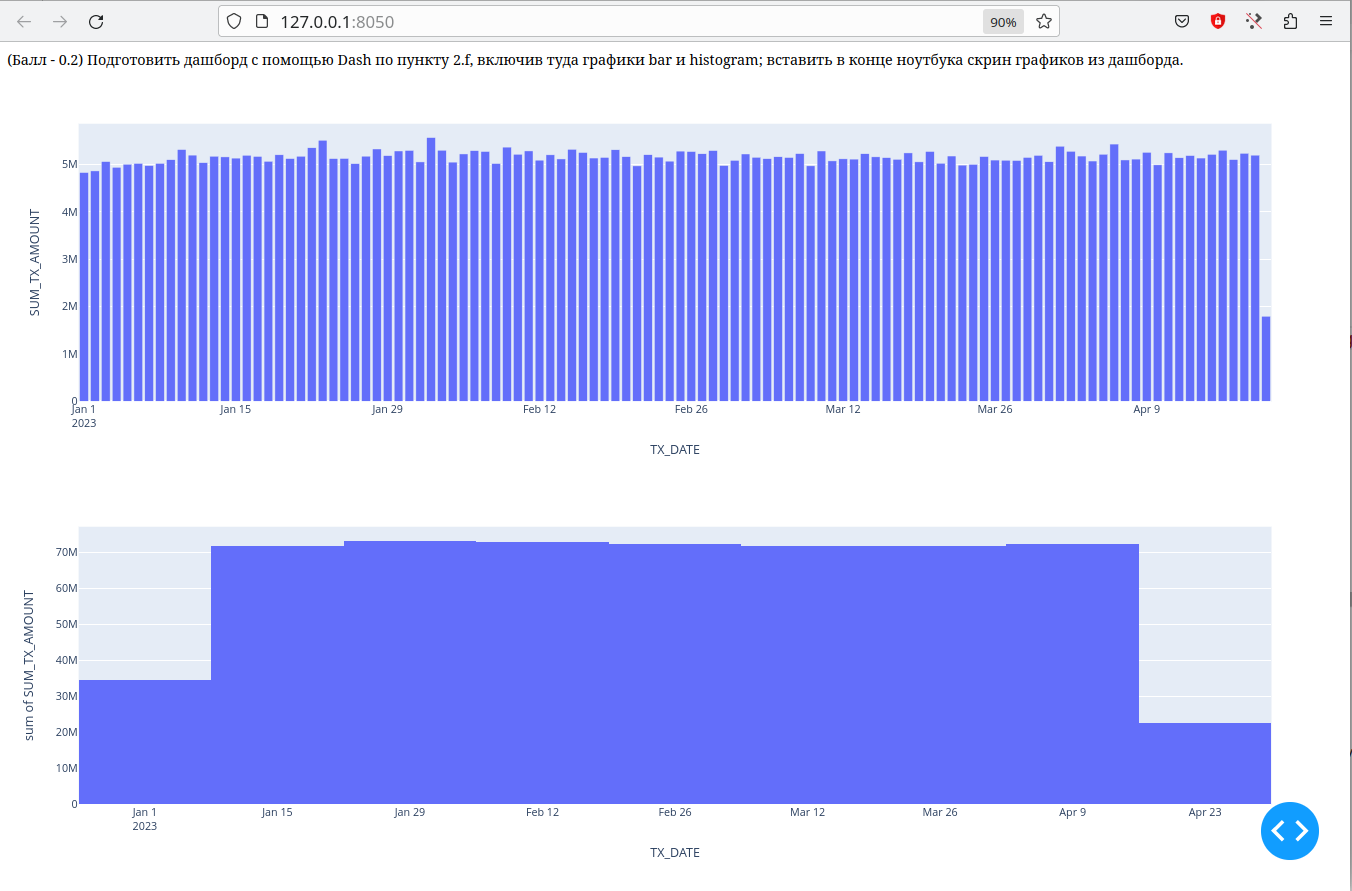